In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [115]:
train = pd.read_csv('data/labeledTrainData.tsv', delimiter='\t')

In [116]:
train

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...


In [117]:
from bs4 import BeautifulSoup
import re
import nltk

In [165]:
def clean_review(sentence):
    sentence = BeautifulSoup(sentence, 'lxml').get_text() 
    sentence = re.sub("[^a-zA-Z]"," ", sentence).lower().strip()
    
    # remove whitespaces
    while "  " in sentence:  
        sentence = sentence.replace("  ", " ")
        
    sentence_split = sentence.split()
    stop_words = nltk.corpus.stopwords.words('english')
    
    # stopword에 정의된 단어는 filter해 줍니다.
    review_cleaned = filter(lambda w: True if w not in stop_words else False, sentence_split)    
    return " ".join(list(review_cleaned))

In [118]:
def cleaning_each_review(sentence):
    sentence = BeautifulSoup(sentence, 'lxml').get_text() 
    sentence = re.sub("[^a-zA-Z]"," ", sentence).lower().strip()
    
    while "  " in cleaned_review: # 공백을 없애줍니다. 
        cleaned_review = cleaned_review.replace("  ", " ")
        
    words_in_cleaned_review = cleaned_review.split(" ")# 단어를 잘라줍니다. 
    stop_words = nltk.corpus.stopwords.words('english')
    
    # nltk에 정의된 무의미한 단어를 삭제해줍니다. 
    words_in_cleaned_review = filter(lambda w: True if w not in stop_words else False, words_in_cleaned_review)    
    return " ".join(list(words_in_cleaned_review))

In [166]:
train['review_clean'] = train['review'].apply(clean_review)

In [167]:
train['review_clean'].head()

0    stuff going moment mj started listening music ...
1    classic war worlds timothy hines entertaining ...
2    film starts manager nicholas bell giving welco...
3    must assumed praised film greatest filmed oper...
4    superbly trashy wondrously unpretentious explo...
Name: review_clean, dtype: object

In [130]:
from keras.preprocessing.text import Tokenizer

In [131]:
tokenizer = Tokenizer()

In [132]:
tokenizer.fit_on_texts(train['review_clean'])

In [133]:
len(tokenizer.word_index)

74065

In [134]:
text_sequence = tokenizer.texts_to_sequences(train['review_clean'])


In [169]:
len(text_sequence)

25000

In [126]:
# text_sequence[:3]

In [135]:
l = pd.Series(text_sequence).apply(len)

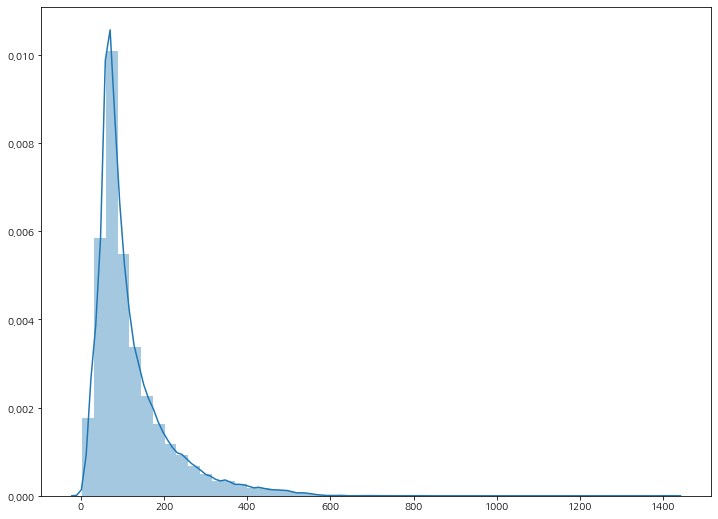

In [136]:
plt.figure(figsize=(12, 9))
sns.distplot(l)

In [129]:
from keras.preprocessing.sequence import pad_sequences

In [137]:
max_length = 300

In [138]:
pad_text = pad_sequences(text_sequence, maxlen=max_length)

In [139]:
pad_text[:5]

array([[    0,     0,     0, ..., 18689,   316,  1356],
       [    0,     0,     0, ...,  1251,  8974,  5471],
       [    0,     0,     0, ...,   700,  1175,  5310],
       [    0,     0,     0, ...,    46,  1561,     2],
       [    0,     0,     0, ...,   239,     1,   462]], dtype=int32)

In [140]:
from sklearn.model_selection import train_test_split

In [141]:
x_train, x_valid, y_train, y_valid = train_test_split(pad_text, 
                                                      train['sentiment'], 
                                                      test_size=0.2, 
                                                      stratify=train['sentiment'], 
                                                      random_state=30,
                                                     )

In [142]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Bidirectional, LSTM, Dropout
from keras.callbacks import ModelCheckpoint

In [143]:
VOCAB_SIZE = len(tokenizer.word_index)+1
EMBEDDING_DIM = 300
INPUT_LENGTH = max_length
BATCH_SIZE = 128

In [144]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_LENGTH))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [145]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [146]:
filename = 'fit-model-tmp-chkpoint.h5'
checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

In [147]:
model.fit(x_train, y_train, 
          validation_data=(x_valid, y_valid),
          epochs=10, 
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint]
         )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 1792/20000 [=>............................] - ETA: 2:05 - loss: 0.6938 - acc: 0.5195

KeyboardInterrupt: 

In [24]:
model.load_weights(filepath=filename)

## Load word2vec model from GoogleNews

[google news](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [148]:
from gensim.models import KeyedVectors

word2vec = KeyedVectors.load_word2vec_format("word2vec/GoogleNews-vectors-negative300.bin", binary=True)

In [149]:
word2vec.most_similar('samsung')

[('htc', 0.7326200008392334),
 ('sony_ericsson', 0.7223767042160034),
 ('droid_x', 0.7148987650871277),
 ('nokia', 0.7076617479324341),
 ('iphone4', 0.6898455619812012),
 ('sony', 0.6818498969078064),
 ('dvd_burner', 0.6713829040527344),
 ('motorola', 0.6689045429229736),
 ('symbian', 0.66512131690979),
 ('xoom', 0.6628588438034058)]

## Extract words from word2vec dictionary

In [150]:
import numpy as np

In [153]:
VOCAB_SIZE = len(tokenizer.index_word) + 1

In [154]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

In [156]:
for word, idx in tokenizer.word_index.items():
    embedding_vector = word2vec[word] if word in word2vec else None
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [157]:
embedding_matrix.shape

(74066, 300)

In [158]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_LENGTH, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 300)          22219800  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 22,675,609
Trainable params: 455,809
Non-trainable params: 22,219,800
__________________________________________________________

In [160]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [161]:
filename = 'fit-model-tmp-chkpoint.h5'
checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

In [163]:
model.fit(x_train, y_train, 
          validation_data=(x_valid, y_valid),
          epochs=10, 
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint]
         )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 118s 6ms/step - loss: 0.2396 - acc: 0.9056 - val_loss: 0.3292 - val_acc: 0.8752

Epoch 00001: val_loss did not improve from 0.32748
Epoch 2/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.2245 - acc: 0.9099 - val_loss: 0.3287 - val_acc: 0.8730

Epoch 00002: val_loss did not improve from 0.32748
Epoch 3/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.2135 - acc: 0.9158 - val_loss: 0.3337 - val_acc: 0.8744

Epoch 00003: val_loss did not improve from 0.32748
Epoch 4/10
20000/20000 [==============================] - 118s 6ms/step - loss: 0.1960 - acc: 0.9225 - val_loss: 0.3627 - val_acc: 0.8730

Epoch 00004: val_loss did not improve from 0.32748
Epoch 5/10
20000/20000 [==============================] - 118s 6ms/step - loss: 0.1793 - acc: 0.9275 - val_loss: 0.3559 - val_acc: 0.8692

Epoch 00005: val_loss did not improve from 0.32748
E